In [73]:
import ruptures as rpt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
import glob

In [77]:
test_data = r"D:\qing_research\1_flood_water\1_flood_water_network\data\Geo\flood\3_extract_all_dma_in_flood_sorted\20200201_20200309\Processed_Flow_DMA_2004.csv"
output_dir = r"D:\qing_research\1_flood_water\1_flood_water_network\data\Geo\flood\3_extract_all_dma_in_flood_sorted\20200201_20200309"

In [63]:
data = pd.read_csv(test_data)  # Replace with your file
data['Time'] = pd.to_datetime(data['Time'])
# data.set_index('Time', inplace=True)

In [64]:
data

,Time,DMA,DataSet,Flow_l_s_
0,2020-02-01 00:00:00,WROWRDMA,BNF,7.666667
1,2020-02-01 00:15:00,WROWRDMA,BNF,6.355556
2,2020-02-01 00:30:00,WROWRDMA,BNF,5.277778
3,2020-02-01 00:45:00,WROWRDMA,BNF,4.677778
4,2020-02-01 01:00:00,WROWRDMA,BNF,4.466667
...,...,...,...,...
3548,2020-03-08 23:00:00,WROWRDMA,BNF,8.866667
3549,2020-03-08 23:15:00,WROWRDMA,BNF,8.355556
3550,2020-03-08 23:30:00,WROWRDMA,BNF,6.922223
3551,2020-03-08 23:45:00,WROWRDMA,BNF,5.666667


In [65]:
# Check for NaN values
nan_indices = data[data['Flow_l_s_'].isna()].index
print(nan_indices)

Index([96, 288, 960, 1344, 2016, 2208, 2496], dtype='int64')


In [66]:
data['Flow_l_s_'] = data['Flow_l_s_'].fillna(data['Flow_l_s_'].mean())

In [67]:
nan_indices = data[data['Flow_l_s_'].isna()].index
print(nan_indices)

Index([], dtype='int64')


In [68]:
# Check for infinite values
inf_indices = data[np.isinf(data['Flow_l_s_'])].index
print("Indices with infinite values:")
print(inf_indices)

Indices with infinite values:
Index([], dtype='int64')


In [69]:
# Prepare the data (using only the flow rate for anomaly detection)
flow_rate = data['Flow_l_s_'].values.reshape(-1, 1)

In [70]:
model = IsolationForest(contamination=0.008, random_state=42)  # Adjust 'contamination' as needed
model.fit(flow_rate)

IsolationForest(contamination=0.008, random_state=42)

In [71]:
# Predict anomalies
data['anomaly'] = model.predict(flow_rate)
# Anomalies are labeled as -1, normal points as 1
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})  # Convert to binary: 1 = anomaly, 0 = normal

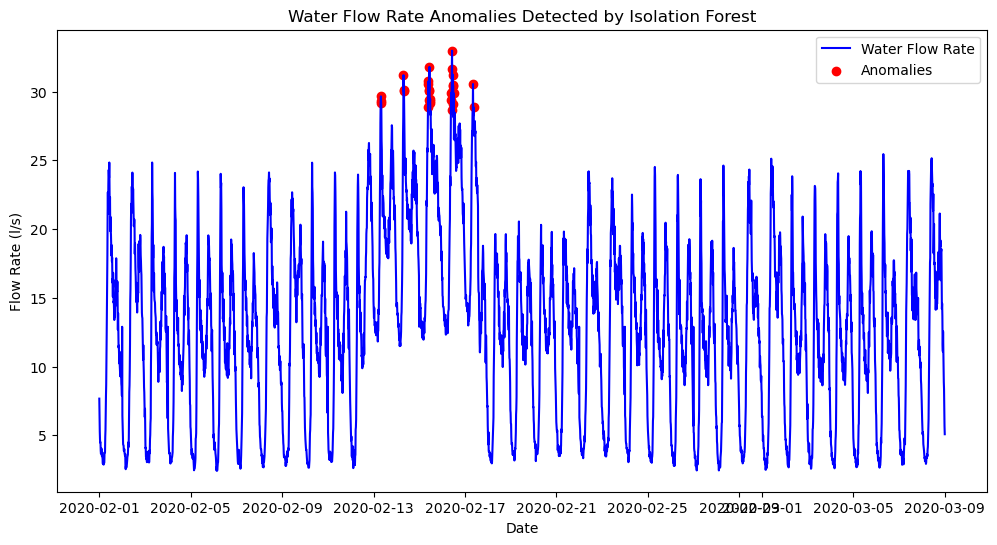

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(data['Time'], data['Flow_l_s_'], label='Water Flow Rate', color='blue')
plt.scatter(data['Time'][data['anomaly'] == 1], data['Flow_l_s_'][data['anomaly'] == 1], color='red', label='Anomalies')
plt.title("Water Flow Rate Anomalies Detected by Isolation Forest")
plt.xlabel("Date")
plt.ylabel("Flow Rate (l/s)")
plt.legend()
plt.show()

In [27]:
anomalies = data[data['anomaly'] == 1]
print("Anomalies detected at:")
print(anomalies)

Anomalies detected at:
                    Time       DMA DataSet  Flow_l_s_  anomaly
9    2020-02-01 02:15:00  AABOTTMA     BNF   0.700000        1
11   2020-02-01 02:45:00  AABOTTMA     BNF   0.666667        1
12   2020-02-01 03:00:00  AABOTTMA     BNF   0.611111        1
14   2020-02-01 03:30:00  AABOTTMA     BNF   0.711111        1
18   2020-02-01 04:30:00  AABOTTMA     BNF   0.711111        1
...                  ...       ...     ...        ...      ...
3499 2020-03-08 10:45:00  AABOTTMA     BNF   2.811111        1
3500 2020-03-08 11:00:00  AABOTTMA     BNF   2.800000        1
3501 2020-03-08 11:15:00  AABOTTMA     BNF   3.155556        1
3527 2020-03-08 17:45:00  AABOTTMA     BNF   2.677778        1
3528 2020-03-08 18:00:00  AABOTTMA     BNF   2.766667        1

[173 rows x 5 columns]


In [74]:
anomaly_count = data['anomaly'].value_counts().get(1, 0)
standard_percentage = anomaly_count / len(data)


In [75]:
standard_percentage

0.008162116521249648

In [80]:
def detect_anomalies(file_path):
    data = pd.read_csv(file_path)
    nan_indices = data[data['Flow_l_s_'].isna()].index
    print(nan_indices)
    data['Flow_l_s_'] = data['Flow_l_s_'].fillna(data['Flow_l_s_'].mean())
    nan_indices = data[data['Flow_l_s_'].isna()].index
    print(nan_indices)
    flow_rate = data['Flow_l_s_'].values.reshape(-1, 1)
    model = IsolationForest(contamination=0.008, random_state=42)
    model.fit(flow_rate)
    data['anomaly'] = model.predict(flow_rate)
    anomaly_count = data['anomaly'].value_counts().get(1, 0)  # Count anomalies
    return anomaly_count / len(data)  # Anomaly percentage

In [81]:
file_list = glob.glob(f"{output_dir}/*.csv")
anomaly_percentages = {file: detect_anomalies(file) for file in file_list}

Index([96, 288, 960, 1344, 2016, 2208, 2496], dtype='int64')
Index([], dtype='int64')
Index([96, 288, 960, 1344, 2016, 2208, 2496], dtype='int64')
Index([], dtype='int64')
Index([  96,  288,  960, 1344, 2016, 2208, 2496, 2693, 2694, 2695, 2696, 2697,
       2698, 2699, 2700, 2701, 2702, 2703, 2885, 2886, 2887, 2888, 2889, 2890,
       2891, 2892, 2893],
      dtype='int64')
Index([], dtype='int64')
Index([2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334,
       2335, 2336, 2337, 2338, 2339, 2340],
      dtype='int64')
Index([], dtype='int64')
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455],
      dtype='int64', length=1060)
Index([], dtype='int64')
Index([  96,  288,  960, 1344, 2016, 2208, 2496, 2695, 2696, 2697, 2698, 2699,
       2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2734, 2735, 2736, 2737,
       2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747,

ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
significant_files = [file for file, perc in anomaly_percentages.items() if perc > standard_percentage]  # Adjust threshold
print("Files with significant anomalies:", significant_files)